# Toxic Comment Codebook


## Loading and EDA

In [17]:


import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install pyldavis

    ## print
    print('Environment: Google Colaboratory.')



Environment: Google Colaboratory.


In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, PCA
import nltk
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
import re
import string
import spacy
import gensim
from gensim import corpora, models, similarities, matutils
from google.colab import drive,files
import time
from collections import Counter
from textblob import TextBlob
from textblob import Word

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [19]:
drive.mount('/content/gdrive')
train = pd.read_csv('gdrive/My Drive/Metis/NLP/NLP_Project/train.csv', usecols = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
      'identity_hate'])
train["unsafe"] = (train.iloc[:,1:].sum(axis = 1) != 0).astype("int")
      

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unsafe
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [21]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,unsafe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.101679
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   unsafe         159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


In [23]:
#random assorment of comments
for i in np.random.randint(0,high= 150000, size = 3):
  print(train.comment_text[i])
  print("\nbreak\n")

":Lsi john, I've already invited you to bring this to WP:RFAR.  WP:AN is another standard venue.  If you wish to make claims against me, please substantiate them with adequate evidence.  Per WP:AGF, the burden of proof rests squarely on your shoulders.  I don't believe my actions have been inappropriate. Charge! 

"

break

Thank you Parkin for helping me out and I promise I will do my best.

break

" the Afd reverted on page Gadugi and Karmosin sanctioned for violating wiki/Wales policy of We Are Nice People Who Do Not Act This Way.  On his user page his lists himself as a ""rebel"" which isn't something that fits in with Wiki's peaceful honeybee meme.  While I respect all peoples right to their views and opinions, after an Afd completes, nominating pages out of retaliation in an attempt to oppress the majority is improper.  I would like this user punished for 1) violating policies and 2) wasting yet more of my valuable time answering stupid and frivolous Afd requests and 3) interferi

In [24]:
#random assorment of good comments
for i in np.random.randint(0,high= len(train[train["unsafe"]==0]), size = 3):
  print(train[train["unsafe"]==0].iloc[i,0])
  print("\nbreak\n")

FYI, I managed to find that verification you were looking for Mr Lane -94.192.243.100

break

"
| style=""padding: 0.1em"" | 

Your request to be unblocked has been granted for the following reason(s):
Autoblock of 86.132.248.231 lifted or expired.

Request handled by:  

|}"

break

"

 Is OhInternet a recreation of Encyclopedia Dramatica? 

To tangent from the above topics…

Oh Internet is not Encyopedia Dramatica as the article supposes. 'Encyclopedia Dramatica' is defined as the domain name 'www.encyclopediadramatica.com' and the intellectual property concerned with ED copyright. OhInternet, however is a different project entirely; notable differences: a new XML coding system, logo and form of satire. To use terms in the article: the site was not 'overhauled' but rather 'replaced'. 

To use Silverseren's analogy, if Wikipedia did rename itself, kept most of its higher administration and stopped using Wikimedia software would it still be Wikipedia? The answer is ""No"". The Wikipedi

In [69]:
#random assorment of bad comments
for i in np.random.randint(0,high= len(train[train["unsafe"]==1]), size = 3):
    print(train[train["unsafe"]==1].iloc[i,0])
    print("\nbreak\n")

Pure trolling 

hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moronhi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moronhi moron hi mo

In [26]:
for text in train.comment_text:
  if text.find("Lion King")>=0:
    print(text)
    print("\n")

"

Yeah, I didn't get far in the game. It was fun to play, but I think either it froze up on me during play, or the Playstation did...I can't remember the reason I stopped playing it. I love Short Circuit 2; the first was good, but for some reason the second had more charm...even if it was a poorer made movie. I was never big into Disney. I think my favorite as a child were The Lion King and Rescurers Down Under-maybe even The Great Mouse Detective. Too much singing for my tastes. I'll take Nightmare/Christmas over The Little Mermaid. Speaking of which, Nightmare/Christmas was just released in 3-D. Toy Story was awesome...lol, I was just reciting some dialogue to the first one two nights ago. I was thinking about buying them. I don't remember seeing the second film all the way through.   (Contact me) "


"

He was ALSO the singing voice of Scar in Lion King, after Jeremy Irons sortof broke his voice after the ""You won't get a sniff without me!"" in Be Prepared.... -X"


Please help 



In [27]:
#rough word count and charcter count
train.comment_text.str.count(" ").describe()
train.comment_text.str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [28]:
#rough word and character count for unsafe comments
train[train["unsafe"]==1].comment_text.str.count(" ").describe()
train[train["unsafe"]==1].comment_text.str.len().describe()

count    16225.000000
mean       303.304037
std        619.402896
min          8.000000
25%         61.000000
50%        128.000000
75%        283.000000
max       5000.000000
Name: comment_text, dtype: float64

In [29]:
#smallest comment bigger than nothing, largest is 5000 chars
train.comment_text.str.len().sort_values()

137062       6
52442        6
109985       8
121074       8
118850       8
          ... 
22378     5000
46583     5000
10769     5000
12895     5000
56441     5000
Name: comment_text, Length: 159571, dtype: int64

In [30]:
#severe toxicity = toxic, insults and obscenties are highly correlated
train.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,unsafe
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,0.967748
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.298666
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,0.702812
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,0.162925
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,0.677324
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,0.280144
unsafe,0.967748,0.298666,0.702812,0.162925,0.677324,0.280144,1.000000


Noticings:
- 90% Safe Comments
- Most non-safe comments classified toxic specifically
- Lots of missing spaces, punctuation errors, etc.
- Most comments under 250 words
- Unsafe comments appear to be typically shorter
- Comments are at least one word
- Comments are cut off at 5000 characters
- Identity_hate, severe_toxic and threat are very rare
- Severe toxicity assures toxicity
- insults and obscenities are highly correlated

## Preprocessing

- strip
- drop numbers, punctuation, and spaces
- address other inconsistencies in strings
- ngrams (in vectorizer)
- try all lemmatizers and stemmers


In [31]:
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words
#spacy tools for later

def preprocessor (text, checker = True):
  text = text.lower()
  # lowers
  
  
  
  replacement_dict = {r'_':" ",
                      r"\d+": "",
                      r"[^\w\s]":"",
                      r'"':"",
                      r'\n':" ",
                      r'\s+':" ",}

  for key, value in replacement_dict.items():
      text = re.sub(key, 
                        value,
                        text)   
  # #removes dashes and underscores
  # #remove numbers
  # #remove quotes
  # #removes \n character
  # #removes punctuation and singular numbers
  
  
  text=text.strip()
  # #removes leading spaces
  # #removes trailing spaces

 
  comment_list = text.split(" ")
  new_comment_list = []

  for word in comment_list:
    if (word in stopwords) & (checker == True):
      pass
    elif (word[:3] != "www") & (word[:4] != "http"):
      new_comment_list.append(word)
  text = " ".join(new_comment_list)
  #removes websites
  # text = TextBlob(text).correct()
  return text
  
def tokenizer (text):
  text = load_model(str(text))
  #lemmatize
  return [token.lemma_ for token in text]



In [32]:

df = train[["comment_text", "unsafe"]].copy()
df.rename({"comment_text":"comment"}, axis =1, inplace = True)
df2= df.copy()
df.comment = df.comment.apply(lambda x: preprocessor(x))


In [33]:
a= time.perf_counter()
print(tokenizer(preprocessor("cool!!!!!!! cool12 is is the boy who can  the restaraunt iffy buggin fuck, ooof ")))
b = time.perf_counter()
print(b-a)


['cool', 'cool', 'boy', 'restaraunt', 'iffy', 'buggin', 'fuck', 'ooof']
0.014027140000507643


## Lemmatization, Stemming and Vectorization



In [34]:
#project on to use spacy to identify key parts of speech in toxic and nontoxic comments

# nlp = spacy.load("en")
# df["comment_spacy"] = list(nlp.pipe(df.comment, n_process = -1))
# safe_comments = df[df["unsafe"]==0]
# unsafe_comments = df[df["unsafe"]==1]

# safe_adj = [token.text.lower() for doc in safe_comments.comment_spacy for token in doc if token.pos_=='ADJ']
# unsafe_adj = [token.text.lower() for doc in unsafe_comments.comment_spacy for token in doc if token.pos_=='ADJ']

# safe_noun = [token.text.lower() for doc in safe_comments.comment_spacy for token in doc if token.pos_=='NOUN']
# unsafe_noun = [token.text.lower() for doc in unsafe_comments.comment_spacy for token in doc if token.pos_=='NOUN']

# safe_verbs = [token.text.lower() for doc in safe_comments.comment_spacy for token in doc if token.pos_=='VERB']
# unsafe_verbs = [token.text.lower() for doc in unsafe_comments.comment_spacy for token in doc if token.pos_=='VERB']

In [35]:
#if you're into stemming
stemmerP = PorterStemmer()
stemmerS = SnowballStemmer("english")
stemmerL = LancasterStemmer()
# stemmerS.stem(df["comment"][1][4])

def stemmer(text):
  text = text.split(" ")
  return " ".join([stemmerS.stem(word) for word in text])
    


In [36]:


vecC =CountVectorizer(
                      ngram_range=(1,3),
                      #adds bigrams
                      max_df = 0.8,
                      #gets rid of super common words
                      min_df = 4,
                      #gets rid of super rare words
                      max_features = 20000,
                      #limits to the top 10000 words
                      preprocessor = stemmer
                      )

vecT =TfidfVectorizer(
                      ngram_range=(1,3),
                      # adds bigrams
                      max_df = 0.8,
                      #gets rid of super common words
                      min_df = 1,
                      # gets rid of super rare words
                      max_features = 20000,
                      #limits to the top 10000 words
                      preprocessor = stemmer
                      )
# I already removed stop words and preprocessed the data. This could have been done in the vectorizor, but I want to break up the computation.


In [37]:
cv = vecC.fit_transform(df["comment"])


In [38]:
tfidf = vecT.fit_transform(df["comment"])

In [39]:
tfidf.shape
# vecT.get_feature_names()
# len(vecC.get_feature_names())

(159571, 20000)

## Dimension Reduction


In [65]:
#k means

from sklearn.cluster import KMeans

feature_names = vecT.get_feature_names()

num_clusters = 10
km = KMeans(n_clusters=num_clusters,n_init=1) # n_init, number of times the K-mean algorithm will run
cluster_labels = km.fit_predict(tfidf)



Text(0.5, 1.0, 'Percentage "unsafe" vs. cluster label')

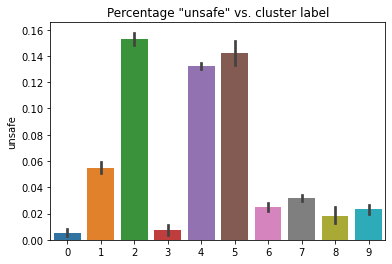

In [66]:

sns.barplot(x=cluster_labels, y=df.unsafe)
plt.title('Percentage "unsafe" vs. cluster label')

In [ ]:
#pca  


# pca_model = PCA(10)
# #since 10% of comments are toxic
# doc_topic = pca_model.fit_transform(tfidf.toarray())
# #fit nmf to the tfidf output
# topic_word = pca_model.components_
# #gets the weights in each topic for each word
# words = vecT.get_feature_names()
# #get the word names
# indexes = pca_model.components_.argsort(axis=1)[:,-1:-10:-1]
# #get the indexes of the top 20 for each category
# topic_words = [[words[word] for e in topics] for topics in indexes]
# #get the topic words
# topic_words[-1]
# #return those last topic's top 20 words, which happens to be our toxic words


In [ ]:
#lsa

# lsa = SVD(2)
# doc_topic = lsa.fit_transform(tfidf)
# topic_word = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_1","component_2"],
#              columns = vecT.get_feature_names())
# topic_word

# def display_topics(model, feature_names, no_top_words, topic_names=None):
#     for ix, topic in enumerate(model.components_):
#         if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
#         print(", ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

# display_topics(lsa, vecT.get_feature_names(), 5)

In [ ]:
#NMF

nmf_model = NMF(6)
#since 10% of comments are toxic
doc_topic = nmf_model.fit_transform(tfidf)
#fit nmf to the tfidf output




In [ ]:
# see how NMF does at identifying toxic comments naturally; not bad!
# activate this after classification below

# a = pd.Series(doc_topic.argsort()[:,9])==9
# confusion_matrix(df["unsafe"],a)
# confusion_matrix(df["unsafe"],a)
# score_this_model(loc_y =df["unsafe"], results = a )


In [ ]:
topic_word = nmf_model.components_
#gets the weights in each topic for each word
words = vecT.get_feature_names()
#get the word names
indexes = nmf_model.components_.argsort(axis=1)[:,-1:-20:-1]
#get the indexes of the top n for each category
topic_words = [[words[word] for word in topic] for topic in indexes]
#get the topic words
topic_words
#return the top 20 words. Last one is the toxic one.

[['articl',
  'dont',
  'sourc',
  'think',
  'like',
  'know',
  'im',
  'peopl',
  'time',
  'need',
  'wikipedia',
  'good',
  'refer',
  'person',
  'chang',
  'tri',
  'way',
  'look',
  'section'],
 ['edit',
  'block',
  'vandal',
  'block edit',
  'continu',
  'vandal page',
  'continu block',
  'continu block edit',
  'vandal page edit',
  'page edit',
  'page',
  'stop',
  'wikipedia',
  'continu vandal',
  'stop continu',
  'revert',
  'edit wikipedia',
  'stop continu vandal',
  'ip'],
 ['talk',
  'page',
  'talk page',
  'user',
  'help',
  'welcom',
  'question',
  'discuss',
  'ask',
  'comment',
  'edit',
  'messag',
  'wikipedia',
  'hope',
  'contrib',
  'talk contrib',
  'user page',
  'post',
  'place'],
 ['delet',
  'articl',
  'speedi',
  'tag',
  'speedi delet',
  'imag',
  'notabl',
  'delet articl',
  'subject',
  'wikipedia',
  'criteria',
  'guidelin',
  'page',
  'note',
  'add',
  'copyright',
  'remov',
  'speedi delet articl',
  'articl delet'],
 ['thank',

In [ ]:
nmf_cluster_labels = pd.Series(doc_topic.argsort()[:,-1])

Text(0.5, 1.0, 'Percentage "unsafe" vs. cluster label')

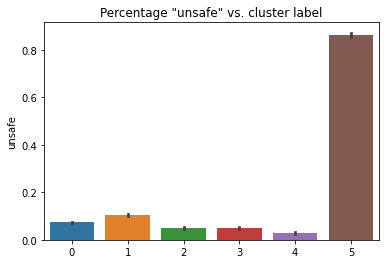

In [ ]:

sns.barplot(x=nmf_cluster_labels, y=df.unsafe)
plt.title('Percentage "unsafe" vs. cluster label')

## LDA

In [40]:
clean_texts = df.comment.apply(lambda x: stemmer(x))

In [43]:
def gen_words(texts):
    new_texts = []
    for text in texts:
        new_text = gensim.utils.simple_preprocess(text, deacc=True)
        new_texts.append(new_text)
    return (new_texts)

data = gen_words(clean_texts)

In [44]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data:
    new = id2word.doc2bow(text)
    corpus.append(new)


In [62]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           passes=3,
                                           alpha="auto")

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.202153 -0.162065       1        1  64.762069
3     -0.221460  0.221312       2        1  18.786042
0      0.132708 -0.292876       3        1   9.467062
2      0.290905  0.233630       4        1   6.984826, topic_info=          Term          Freq         Total Category  logprob  loglift
12        page  56506.000000  56506.000000  Default  30.0000  30.0000
47      articl  74123.000000  74123.000000  Default  29.0000  29.0000
142      delet  25986.000000  25986.000000  Default  28.0000  28.0000
196  wikipedia  37712.000000  37712.000000  Default  27.0000  27.0000
16        talk  33905.000000  33905.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
193      video   1462.759447   2021.587625   Topic4  -5.4328   2.3379
36         guy   1669.839548   4218.358005   Topic4  -5.3004   1.7347
475     mother   1266.891481   1639.171880   Topic4  -5.5765   2.4038
976        die   1249.469879   1612.599467   Topic4  -5.5904   2.4063
651         hi   1266.598430   6074.280961   Topic4  -5.5768   1.0937

[260 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1299       1  0.999867  account
223        1  0.999842    accus
1594       1  0.999685   action
121        1  0.739448       ad
121        2  0.011317       ad
...      ...       ...      ...
307        1  0.562696     year
307        2  0.413703     year
307        4  0.023644     year
11370      1  0.000537     youi
11370      4  0.999102     youi

[393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

## Spacy Classification Attempt (ignore)


In [ ]:
#spacy classification







In [ ]:
# def gen_words(texts):
#     final = []
#     for text in texts:
#         new = gensim.utils.simple_preprocess(text, deacc=True)
#         final.append(new)
#     return (final)

# data_words = gen_words(ldf2.comment)

# print (data_words[0][0:20])

In [ ]:
# id2word = corpora.Dictionary(data_words)

# corpus = []
# for text in data_words:
#     new = id2word.doc2bow(text)
#     corpus.append(new)

# print (corpus[0][0:20])

# word = id2word[[0][:1][0]]
# print (word)

In [ ]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=30,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha="auto")

In [ ]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
# vis

## Supervised Learning Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [ ]:
#train test split to create a test set; will later add cross val score for validation

X_trainer, X_tester, y_train, y_test = train_test_split(df["comment"], df["unsafe"], test_size=0.2, random_state=42)
X_train_cv = vecC.fit_transform(X_trainer)
X_test_cv  = vecC.transform(X_tester)
X_train_tv = vecT.fit_transform(X_trainer)
X_test_tv  = vecT.transform(X_tester)

In [ ]:
#pick CountVec or TfidfVec
X_train = X_train_cv
X_test = X_test_cv


X_train = X_train_tv
X_test = X_test_tv

In [ ]:
#from previous notebook
#add scoring model for quick and easy analysis
def score_this_model(model = None, loc_X = X_test, loc_y = y_test, results = None):
    try:  
      results = model.predict(loc_X)
    except:
      pass
    print("accuracy: {:6.4f}".format(accuracy_score(loc_y, results)))    
    print("precision: {:6.4f}".format(precision_score(loc_y, results)))
    print("recall: {:6.4f}".format(recall_score(loc_y, results)))
    print("roc_auc_score: {:6.4f}".format(roc_auc_score(loc_y, results)))
    print("f1_score: {:6.4f}".format(f1_score(loc_y, results)))
    print(confusion_matrix(loc_y, results))

In [ ]:


# Create a logistic regression model to use

#Ran GridsearchCV to figure out the optimal C_value
# log_m = LogisticRegression()
# C_range = np.logspace(-4, 4, 20)
# param_grid = {"C":C_range}
# grid = GridSearchCV(log_m, param_grid, cv=5, scoring='accuracy')
# grid.fit(X_train, y_train)


#No class balancing
log_m_ncb = LogisticRegression(C=5, max_iter = 10000)
log_m_ncb.fit(X_train, y_train)
y_pred = log_m_ncb.predict(X_test)
score_this_model(log_m_ncb)
print("Log-loss: {:6.4f}".format(log_loss(y_test, log_m_ncb.predict_proba(X_test))))

# #class balancing through imblearn
# log_m_imb = LogisticRegression(grid.best_params_, max_iter = 10000 )
# log_m_imb.fit(X_train_smote, y_train_smote)
# y_pred = log_m_imb.predict(X_test)
# score_this_model(log_m_imb)
# print("Log-loss: {:6.4f}".format(log_loss(y_test, log_m_imb.predict_proba(X_test))))




accuracy: 0.9603
precision: 0.8940
recall: 0.6914
roc_auc_score: 0.8411
f1_score: 0.7798
[[28405   266]
 [ 1001  2243]]
Log-loss: 0.1094


In [ ]:
confusion = confusion_matrix(y_test, log_m_ncb.predict(X_test))
plt.figure(dpi=1200)
sns.heatmap(confusion,
            cmap = "Blues",
            annot=True, 
            square=True,
            xticklabels = ["Non-Toxic", "Toxic"],
            yticklabels = ["Non-Toxic", "Toxic"],
            fmt = "g")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Toxic Comment Classification Confusion Matrix');

In [ ]:
# function to determine missed comments to improve accuracy

# a = pd.DataFrame(X_tester)
# a["act"] = y_test
# a["pred"]= y_pred
# missing = a[a["act"] != a["pred"]]

predictions = log_m_ncb.predict(tfidf)
actual = df2["unsafe"]
c=0

for i in range(len(predictions)):

  if predictions[i] != actual[i]:
    if predictions[i]<actual[i]:
      a = "missed bad"
    else:
      a = "actually good"
    print(a)
    print(train["comment_text"][i])
    print("\n")
    c+=1
  if c>100:
    break

In [ ]:
# mnb = MultinomialNB()
# C_range = np.logspace(-4, 4, 20)
# param_grid = {"C":C_range}
# grid = GridSearchCV(mnb, param_grid, cv=10, scoring='accuracy')
# grid.fit(X_train, y_train)


mnb = MultinomialNB()
mnb.fit(X_train, y_train)
score_this_model(mnb)

In [ ]:
# n_estimators = list(range(25, 251, 25))
# max_features =  list(range(5,51,5))
# param_grid = {"n_estimators":n_estimators, "max_features" :max_features}
# grid = GridSearchCV(randomforest, param_grid, cv=10, scoring="accuracy")
# grid.fit(X_train_smote, y_train_smote)


#set these models with the results from CV below

# randomforest = RandomForestClassifier()
# randomforest.fit(X_train, y_train)
# score_this_model(randomforest)


## Markov Chain

In [ ]:
def markov_chain(corpus):
  m_dict = {}
  for text in corpus:
    words = tokenizer(text)
    for index, current_word in enumerate(words):
      try:      
        m_dict[current_word].append(words[index+1])
      except:
        try:
          m_dict[current_word] = [words[index+1]]
        except:
          pass
  return m_dict

In [ ]:
#create dictionary of all words in unsafe comments less than 500 characters and our algorithm guessed correctly
guessed = log_m_ncb.predict(tfidf)
df2.comment = df2.comment.apply(lambda x : preprocessor(x, checker = False))
markov_dict = markov_chain(df2[((guessed==1)&(df2["unsafe"]==1)&(df2["comment"].str.len()<500))]["comment"])

In [ ]:
def generate_sentence(quote_dict, count=10):

    # capitalize the first word
    word1 = np.random.choice(list(quote_dict.keys()))
    sentence = word1.capitalize()
    wordlist = [sentence]

    current_word = word1
    for i in range(count-1):
        try:
          next_word = np.random.choice(quote_dict[current_word])
          current_word = next_word
          wordlist.append(next_word)
        except:
          break

    return " ".join(wordlist)+"."

In [ ]:
generate_sentence(markov_dict)

## ScatterText


In [ ]:
df2 = df.copy()
df2.unsafe = df2.unsafe.apply(lambda x : "T" if x == 1 else "S")
corpus = st.CorpusFromPandas(df2,
                             category_col='unsafe',
                             text_col='comment',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()
html = st.produce_scattertext_explorer(
        corpus,
        category="T",
        category_name='Toxic',
        not_category_name='Safe',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )


KeyboardInterrupt: ignored

In [ ]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
file_name = 'NLP/tryit.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700
HTML(html)

